<a href="https://colab.research.google.com/github/Divyaanshvats/FIDROX_ASSIGNMENTS/blob/main/FIDROX_ISOLATION_FOREST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AccessAI: Detecting Anomalous Swipe Behavior in Physical Access Control Systems(ML)**

# **IMPORT ALL THE REQUIRE LIBRARIES**

In [232]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import os
np.random.seed(42)
random.seed(42)
NUM_DAYS = 30
SWIPES_PER_DAY = 1000
TOTAL_RECORDS = NUM_DAYS * SWIPES_PER_DAY
user_ids = [f"U{str(i).zfill(3)}" for i in range(1, 101)]
doors = {
    "D01": "Main Entrance",
    "D02": "East Wing",
    "D03": "Server Room",# restricted
    "D04": "HR Department",
    "D05": "Rooftop Access",# rarely used
    "D06": "Finance Room",
    "D07": "Cafeteria",
    "D08": "Basement Storage",# rarely used
}

# **RANDOM GENERATION OF DATASET(SAME AS DBSCAN)**

In [233]:
data = []
start_date = datetime(2025, 5, 1)
for i in range(TOTAL_RECORDS):
    current_date = start_date + timedelta(days=i // SWIPES_PER_DAY)
    if np.random.rand() < 0.8:
        hour = np.random.randint(8, 19)
    else:
        hour = np.random.choice([0, 1, 2, 3, 4, 22, 23])

    minute = np.random.randint(0, 60)
    second = np.random.randint(0, 60)
    timestamp = current_date.replace(hour=hour, minute=minute, second=second)
    user = random.choice(user_ids)
    door = random.choices(list(doors.keys()), weights=[25, 20, 5, 15, 2, 10, 20, 3])[0]
    direction = random.choice(["IN", "OUT"])
    result = "Success" if np.random.rand() > 0.05 else "Failed"
    if np.random.rand() < 0.01:
        for _ in range(5):
            anomaly_timestamp = timestamp + timedelta(seconds=random.randint(1, 30))
            data.append([anomaly_timestamp, user, door, doors[door], direction, "Failed"])

    data.append([timestamp, user, door, doors[door], direction, result])
df = pd.DataFrame(data, columns=["Timestamp", "UserID", "DoorID", "DoorName", "Direction", "Result"])
df.head()

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed
4,2025-05-01 10:43:54,U012,D01,Main Entrance,IN,Success


In [234]:
output_path = "/mnt/data/AccessAI_Simulated_Swipe_Logs.csv"
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df.to_csv(output_path, index=False)
output_path

'/mnt/data/AccessAI_Simulated_Swipe_Logs.csv'

In [235]:
df = pd.read_csv("/mnt/data/AccessAI_Simulated_Swipe_Logs.csv")
df.head(3)

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success


In [236]:
len(df)#length of dataset

31505

# **FEATURE ENGINEERING**

In [237]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['IsFailed'] = (df['Result'] == 'Failed').astype(int)
df['IsOddHour'] = df['Hour'].apply(lambda x: 1 if x < 6 or x > 21 else 0)
df['IsRestrictedDoor'] = df['DoorName'].isin(['Server Room', 'Rooftop Access', 'Basement Storage']).astype(int)
df['DirectionEncoded'] = (df['Direction'] == 'IN').astype(int)

# **SELECTING FEATURES AND TRAINING THE MODEL**

In [238]:
from sklearn.ensemble import IsolationForest

# Select features
features_iforest = df[['Hour', 'IsFailed', 'IsOddHour', 'IsRestrictedDoor', 'DirectionEncoded']]

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.04, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(features_iforest)
df['is_anomaly'] = (df['anomaly_score'] == -1).astype(int)

# **DATA VISUALIZATION**

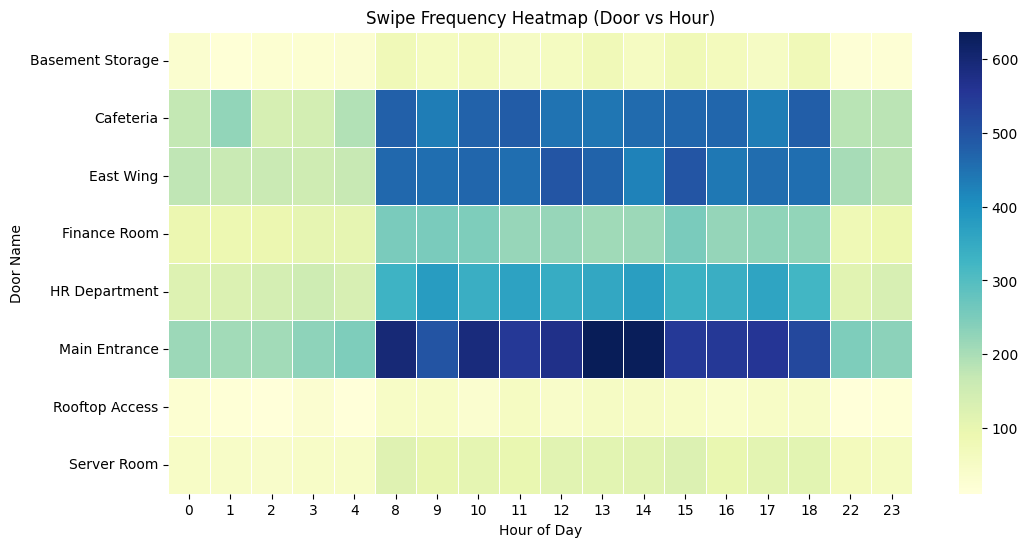

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table: count of swipes by Hour and DoorName
heatmap_data = df.pivot_table(index='DoorName', columns='Hour', values='UserID', aggfunc='count', fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Swipe Frequency Heatmap (Door vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Door Name')
plt.show()

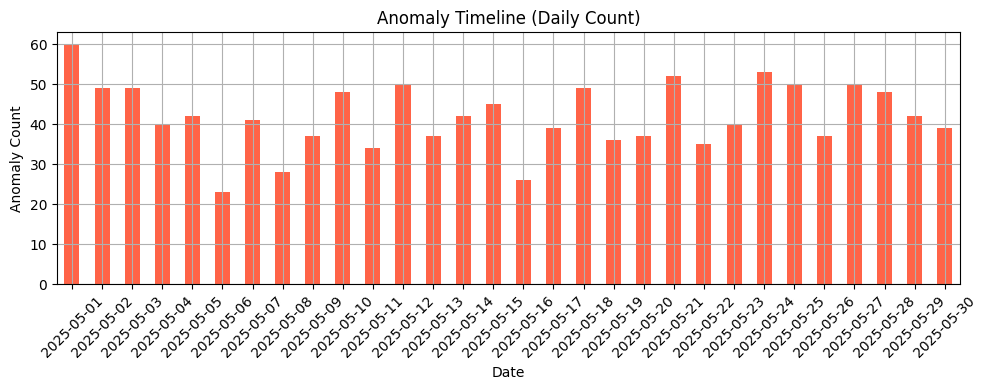

In [240]:
df['Date'] = df['Timestamp'].dt.date
daily_anomalies = df[df['is_anomaly'] == 1].groupby('Date').size()

plt.figure(figsize=(10, 4))
daily_anomalies.plot(kind='bar', color='tomato')
plt.title('Anomaly Timeline (Daily Count)')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

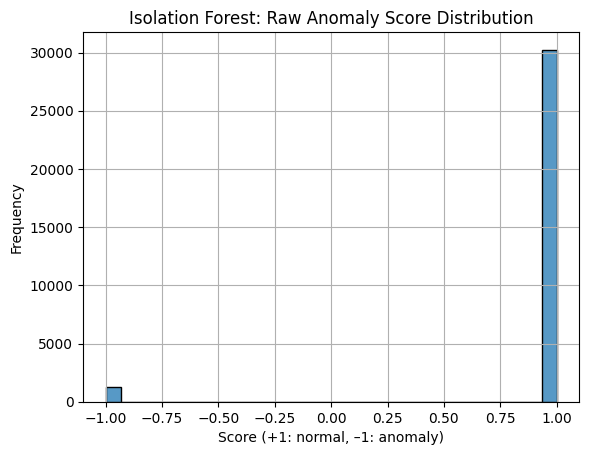

In [241]:
sns.histplot(df['anomaly_score'], bins=30, kde=False)
plt.title('Isolation Forest: Raw Anomaly Score Distribution')
plt.xlabel('Score (+1: normal, –1: anomaly)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: xlabel='anomaly_score', ylabel='Count'>

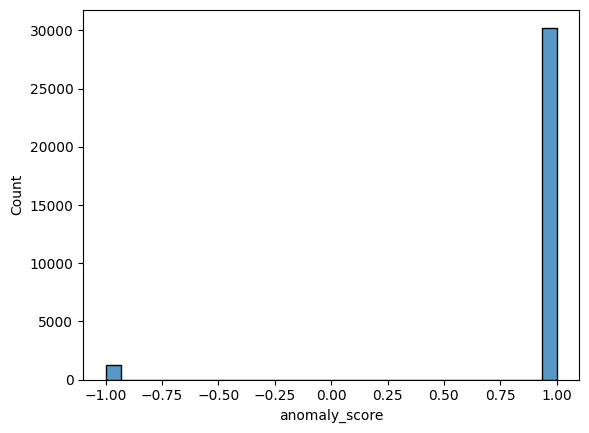

In [242]:
sns.histplot(df['anomaly_score'], bins=30, kde=False)

In [243]:
df['anomaly_raw_score'] = iso_forest.decision_function(features_iforest)
df['anomaly_raw_score'][:5]


,anomaly_raw_score
0,0.186880
1,0.230547
2,0.230547
3,0.059586
4,0.237359


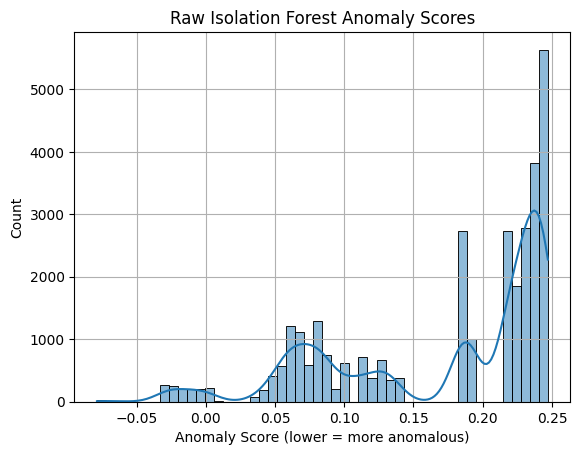

In [244]:
# Histogram of raw scores
sns.histplot(df['anomaly_raw_score'], bins=50, kde=True)
plt.title('Raw Isolation Forest Anomaly Scores')
plt.xlabel('Anomaly Score (lower = more anomalous)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [245]:
sum(df['anomaly_raw_score']<0)

1258

# **Let us consider anything below 0.05 as Anomally**

In [246]:
sum(df['anomaly_raw_score']<0.05)

1886

In [247]:
threshold = 0.05
df['custom_is_anomaly'] = (df['anomaly_raw_score'] < threshold).astype(int)
print("Number of custom anomalies:", df['custom_is_anomaly'].sum())

Number of custom anomalies: 1886


# **CHECKED FOR DIFFERENT CONTAMINATION SCORE AND HENCE OBSERVATION AS INDICATED BELOW**

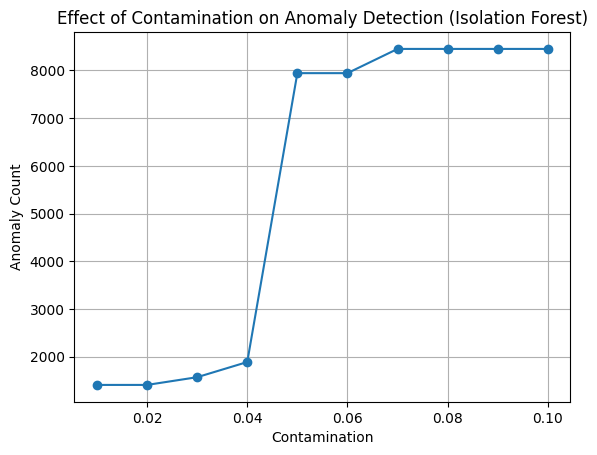

In [248]:
import matplotlib.pyplot as plt

contamination_vals = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
anomaly_counts = [1406, 1406, 1568, 1886, 7944, 7944, 8452, 8452, 8452, 8452]

plt.plot(contamination_vals, anomaly_counts, marker='o')
plt.xlabel('Contamination')
plt.ylabel('Anomaly Count')
plt.title('Effect of Contamination on Anomaly Detection (Isolation Forest)')
plt.grid(True)
plt.show()


In [249]:
df[df['custom_is_anomaly'] == 0].sort_values('anomaly_raw_score').head(40000)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsFailed,IsOddHour,IsRestrictedDoor,DirectionEncoded,anomaly_score,is_anomaly,Date,anomaly_raw_score,custom_is_anomaly
28,2025-05-01 08:36:48,U028,D05,Rooftop Access,OUT,Success,8,0,0,1,0,1,0,2025-05-01,0.050658,0
2875,2025-05-03 08:25:27,U032,D05,Rooftop Access,OUT,Success,8,0,0,1,0,1,0,2025-05-03,0.050658,0
7901,2025-05-08 08:28:03,U013,D08,Basement Storage,OUT,Success,8,0,0,1,0,1,0,2025-05-08,0.050658,0
11275,2025-05-11 08:45:44,U065,D08,Basement Storage,OUT,Success,8,0,0,1,0,1,0,2025-05-11,0.050658,0
18764,2025-05-18 08:16:09,U040,D08,Basement Storage,OUT,Success,8,0,0,1,0,1,0,2025-05-18,0.050658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31482,2025-05-30 12:38:29,U003,D04,HR Department,IN,Success,12,0,0,0,1,1,0,2025-05-30,0.247053,0
20,2025-05-01 12:22:38,U086,D02,East Wing,IN,Success,12,0,0,0,1,1,0,2025-05-01,0.247053,0
31488,2025-05-30 12:08:23,U035,D02,East Wing,IN,Success,12,0,0,0,1,1,0,2025-05-30,0.247053,0
44,2025-05-01 12:47:19,U020,D02,East Wing,IN,Success,12,0,0,0,1,1,0,2025-05-01,0.247053,0


In [250]:
df[df['custom_is_anomaly'] == 1].sort_values('anomaly_raw_score').tail(1500)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsFailed,IsOddHour,IsRestrictedDoor,DirectionEncoded,anomaly_score,is_anomaly,Date,anomaly_raw_score,custom_is_anomaly
25805,2025-05-25 22:58:07,U050,D03,Server Room,OUT,Success,22,0,1,1,0,-1,1,2025-05-25,-0.026261,1
30736,2025-05-30 22:49:43,U087,D03,Server Room,OUT,Success,22,0,1,1,0,-1,1,2025-05-30,-0.026261,1
21861,2025-05-21 22:52:06,U065,D03,Server Room,OUT,Success,22,0,1,1,0,-1,1,2025-05-21,-0.026261,1
9252,2025-05-09 22:32:57,U023,D03,Server Room,OUT,Success,22,0,1,1,0,-1,1,2025-05-09,-0.026261,1
25965,2025-05-25 22:08:57,U040,D03,Server Room,OUT,Success,22,0,1,1,0,-1,1,2025-05-25,-0.026261,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18347,2025-05-18 18:17:56,U077,D08,Basement Storage,IN,Success,18,0,0,1,1,1,0,2025-05-18,0.047096,1
18129,2025-05-18 18:31:55,U087,D03,Server Room,IN,Success,18,0,0,1,1,1,0,2025-05-18,0.047096,1
18370,2025-05-18 18:07:50,U058,D08,Basement Storage,IN,Success,18,0,0,1,1,1,0,2025-05-18,0.047096,1
31045,2025-05-30 18:56:32,U012,D03,Server Room,IN,Success,18,0,0,1,1,1,0,2025-05-30,0.047096,1


# **PCA ANALYSIS**

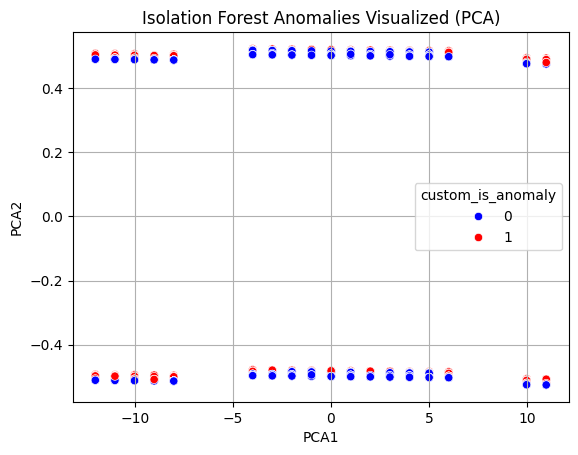

In [251]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_iforest)
df['PCA1'], df['PCA2'] = pca_result[:, 0], pca_result[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='custom_is_anomaly', palette=['blue', 'red'])
plt.title('Isolation Forest Anomalies Visualized (PCA)')
plt.grid(True)
plt.show()

In [252]:
df[df['custom_is_anomaly'] == 1].sort_values('anomaly_raw_score').head(10)

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsFailed,IsOddHour,IsRestrictedDoor,DirectionEncoded,anomaly_score,is_anomaly,Date,anomaly_raw_score,custom_is_anomaly,PCA1,PCA2
7132,2025-05-07 23:57:15,U021,D05,Rooftop Access,IN,Failed,23,1,1,1,1,-1,1,2025-05-07,-0.078576,1,10.980259,0.492400
10506,2025-05-10 00:35:39,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.076314,1,-12.011620,-0.492770
10508,2025-05-10 00:35:44,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.076314,1,-12.011620,-0.492770
10505,2025-05-10 00:36:06,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.076314,1,-12.011620,-0.492770
10507,2025-05-10 00:35:48,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.076314,1,-12.011620,-0.492770
10504,2025-05-10 00:36:02,U089,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-10,-0.076314,1,-12.011620,-0.492770
16502,2025-05-16 00:14:45,U011,D08,Basement Storage,OUT,Failed,0,1,1,1,0,-1,1,2025-05-16,-0.076314,1,-12.011620,-0.492770
19712,2025-05-19 00:13:25,U063,D03,Server Room,OUT,Failed,0,1,1,1,0,-1,1,2025-05-19,-0.076314,1,-12.011620,-0.492770
6358,2025-05-07 22:45:01,U041,D03,Server Room,IN,Failed,22,1,1,1,1,-1,1,2025-05-07,-0.075908,1,9.980617,0.493033
7092,2025-05-07 22:57:46,U040,D03,Server Room,IN,Failed,22,1,1,1,1,-1,1,2025-05-07,-0.075908,1,9.980617,0.493033


In [253]:
# Z-score based anomaly detection
df['Z_Hour'] = np.abs((df['Hour'] - df['Hour'].mean()) / df['Hour'].std())
df['Z_Failed'] = np.abs((df['IsFailed'] - df['IsFailed'].mean()) / df['IsFailed'].std())

# Create anomaly column if z > 3
df['Anomaly_Z'] = ((df['Z_Hour'] > 3) | (df['Z_Failed'] > 3)).astype(int)

In [254]:
(df['Anomaly_Z'] == 1).astype(int)

,Anomaly_Z
0,0
1,0
2,0
3,1
4,0
...,...
31500,0
31501,0
31502,0
31503,0


In [255]:
df['Consensus'] = ((df['custom_is_anomaly'] == 1) & (df['Anomaly_Z'] == 1)).astype(int)
print("Anomalies agreed by both:", df['Consensus'].sum())

Anomalies agreed by both: 1057


# **USE CASE FOR ISOLATION FOREST**

1. Detects unusual swipe patterns such as failed attempts at odd hours or on
restricted doors.

2. Can trigger real-time alerts when access behavior deviates from normal patterns.

3. Helps security teams prioritize investigations by ranking events based on anomaly scores.

4. Reduces manual review effort by automatically filtering normal swipe activity.

5. Can be retrained periodically to adapt to evolving access behavior or policy changes.